In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Residual network


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, \
     ReLU, Add, MaxPool2D, GlobalAvgPool2D, Dense, SeparableConv2D
from tensorflow import keras
import numpy as np
from tensorflow.keras.optimizers import RMSprop,Adam,SGD

In [ ]:
# take inputs tensor x, number of filters , the kernel size ,  strides
# apply a convolution layer followed by batch norm and relu activation

def conv_batchnorm_relu(x, filters, kernel_size, strides):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,
               padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

In [ ]:
# take inputs tensor x, number of filters , the kernel size ,  strides
# apply a convolution layer followed by batch norm and relu activation

def sep_conv_batchnorm_relu(x, filters, kernel_size, strides):
    x = SeparableConv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

In [ ]:
# apply 1x1 conv-batchnorm-relu 
# apply 3x3 conv-batchnorm-relu
# apply 1x1 convolution layer with 4 times the filters 
# apply batch normalization
# add to this tensor the input
# apply relu
def identity_block(tensor, filters):
    x = conv_batchnorm_relu(tensor, filters=filters, kernel_size=1, strides=1)
    x = conv_batchnorm_relu(x, filters=filters, kernel_size=3, strides=1)
    x = Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)  # notice: filters=4*filters
    x = BatchNormalization()(x)

    x = Add()([x, tensor])
    x = ReLU()(x)
    return x

In [ ]:
def projection_block(tensor, filters, strides):
    # left stream
    x = conv_batchnorm_relu(tensor, filters=filters, kernel_size=1, strides=strides) #[v]
    x = conv_batchnorm_relu(x, filters=filters, kernel_size=3, strides=1)
    x = Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)  # notice: filters=4*filters
    x = BatchNormalization()(x)

    # right stream
    shortcut = Conv2D(filters=4*filters, kernel_size=1, strides=strides)(tensor)  # notice: filters=4*filters
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

In [ ]:
def resnet_block(x, filters, reps, strides):
    x = projection_block(x, filters=filters, strides=strides)
    for _ in range(reps-1):
        x = identity_block(x, filters=filters)
    return x

In [ ]:
#input = Input(shape=(256, 256, 3))
input = Input(shape=(400,400,3))

x = conv_batchnorm_relu(input, filters=64, kernel_size=7, strides=2)  # [3]: 7x7, 64, strides 2
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)  # [3]: 3x3 max mool, strides 2

x = SeparableConv2D(filters=64, kernel_size=7, strides=2)(x)
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

x = resnet_block(x, filters=64, reps=3, strides=1)
#x = resnet_block(x, filters=128, reps=4, strides=2)  # strides=2 ([2]: conv3_1)
#x = resnet_block(x, filters=256, reps=6, strides=2)  # strides=2 ([2]: conv4_1)
#x = resnet_block(x, filters=512, reps=3, strides=2)  # strides=2 ([2]: conv5_1)

x = GlobalAvgPool2D()(x)  # [3]: average pool *it is not written any pool size so we use Global
x = Dense(64, activation='softmax')(x) 
x = Dense(32, activation='softmax')(x) 
#output = Dense(2, activation='softmax')(x)  # [3]: 1000-d fc, softmax
output = Dense(5, activation='softmax')(x)  # [3]: 1000-d fc, softmax

from tensorflow.keras import Model

model = Model(input, output)

In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 200, 200, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 200, 200, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 200, 200, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
cd /content/drive/MyDrive/diabetic_retinopathy_dataset_kaggle

/content/drive/.shortcut-targets-by-id/1Jb34gT37YZO0kXkHTlICygXmCmd570d4/diabetic_retinopathy_dataset_kaggle


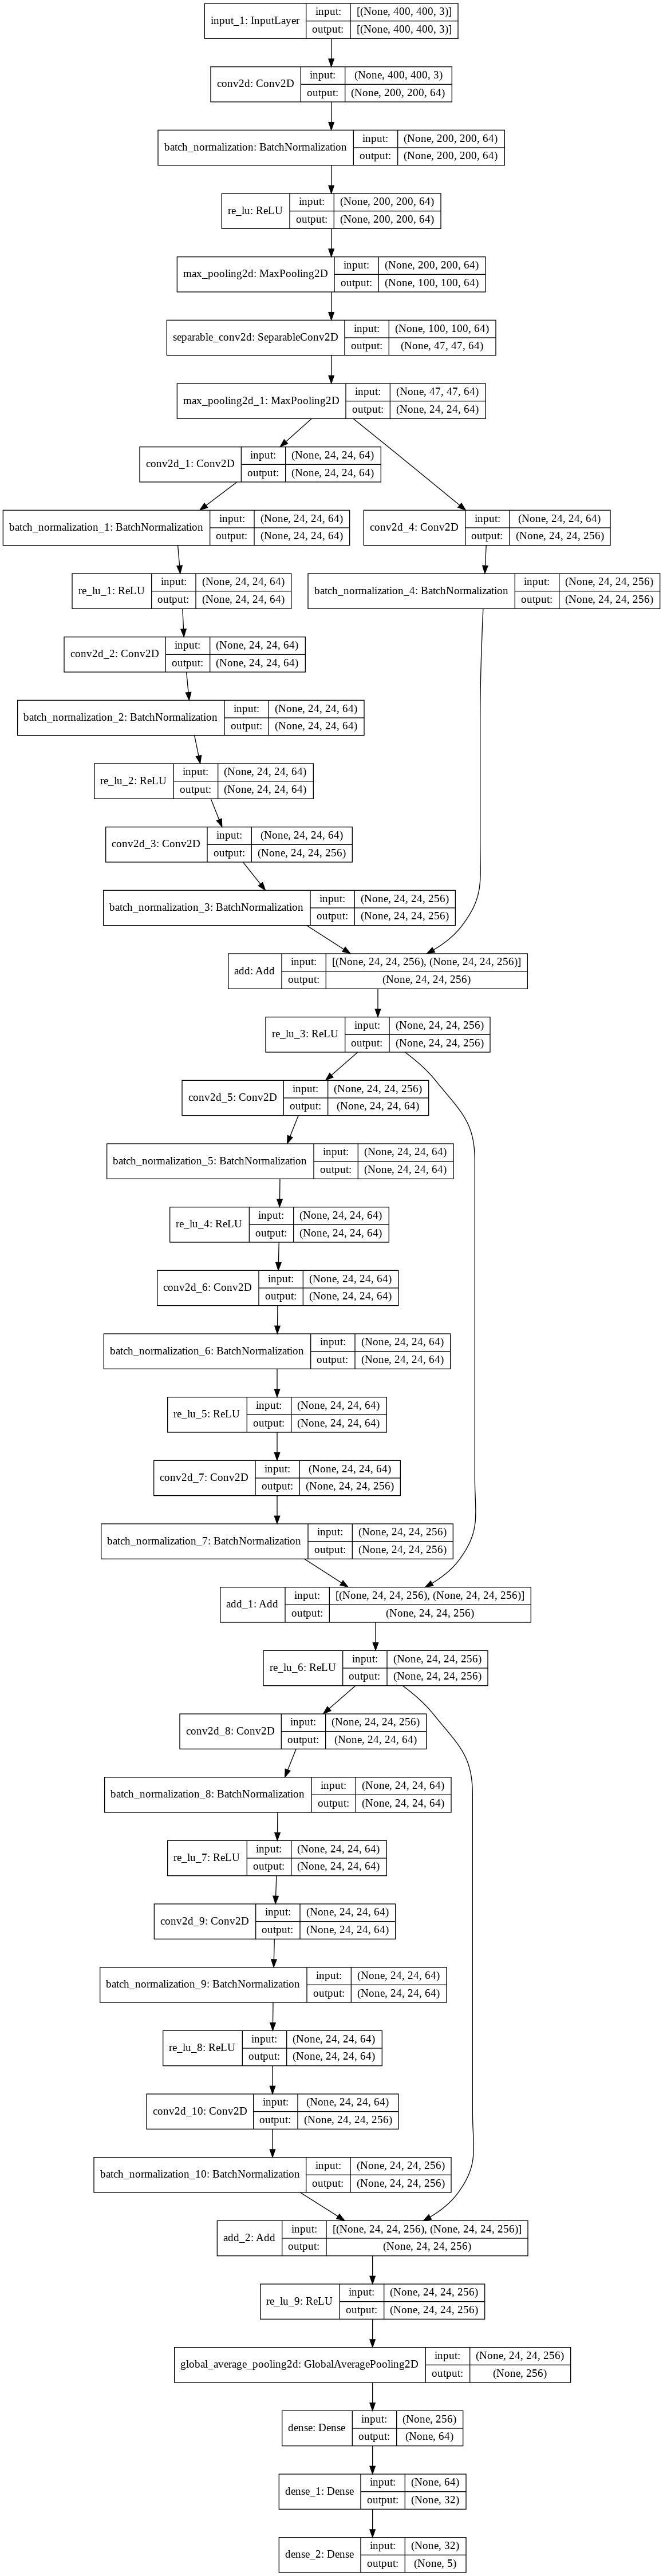

In [ ]:
keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
x_train = np.load('/content/drive/MyDrive/diabetic_retinopathy_dataset_kaggle/binary dataset/X_train_DR_binary.npy')
x_test = np.load('/content/drive/MyDrive/diabetic_retinopathy_dataset_kaggle/binary dataset/X_test_DR_binary.npy')
y_train = np.load('/content/drive/MyDrive/diabetic_retinopathy_dataset_kaggle/binary dataset/Y_train_DR_binary.npy')
y_test = np.load('/content/drive/MyDrive/diabetic_retinopathy_dataset_kaggle/binary dataset/Y_test_DR_binary.npy')


(x_train, x_test) = map(
    lambda data: data.astype("float32") / 255,
    (x_train, x_test))

num_classes=2

(y_train, y_test) = map(
    lambda data: keras.utils.to_categorical(data, num_classes),
    (y_train, y_test))

test = np.expand_dims(x_train[0, :, :, :], 0)
print("x_train shape:", x_train.shape)
print("Train Samples: ", x_train.shape[0])
print("Test Samples: ", x_test.shape[0])

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
'''(y_train, y_test) = map(
    lambda data: keras.utils.to_categorical(data, 3),
    (y_train, y_test))'''

In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[256, 256, 3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [ ]:
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
cnn.compile(loss = 'binary_crossentropy',
             optimizer = Adam(learning_rate=0.001),
             metrics = ['accuracy',f1_m, precision_m, recall_m])

In [ ]:
model.compile(loss = 'binary_crossentropy',
             optimizer = Adam(learning_rate=0.001),
             metrics = ['accuracy',f1_m, precision_m, recall_m])

In [ ]:
tf.__version__

In [ ]:
cnn.fit(x = x_train,y=y_train, epochs = 25)

In [ ]:
history1=cnn.fit(x = x_train,
                    y = y_train,
                   batch_size = 32,
                   epochs = 30,
                   validation_split = 0.2,
                   shuffle = True)


In [ ]:
history = model.fit(x = x_train,
                    y = y_train,
                   batch_size = 32,
                   epochs = 30,
                   validation_split = 0.2,
                   shuffle = True)

In [ ]:
model.evaluate(x_test,y_test)

In [ ]:
x_test_exp = np.load('/content/drive/MyDrive/diabetic_retinopathy_dataset_kaggle/balanced dataset 5 categories/4 classes/X_test_binaryclass_balanced.npy')
y_test_exp = np.load('/content/drive/MyDrive/diabetic_retinopathy_dataset_kaggle/balanced dataset 5 categories/4 classes/Y_test_binaryclass_balanced.npy')

In [ ]:
x_test_exp = x_test_exp.astype("float32") / 255
y_test_exp = keras.utils.to_categorical(y_test_exp, 2)

In [ ]:
model.evaluate(x_test_exp, y_test_exp)

In [ ]:
plt.rcParams.update({'font.size': 20})

In [ ]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    plt.figure(figsize=(10,10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
target_names = ['No DR', 'DR']

Y_pred = model.predict(x_test)
y_preds = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
rounded_labels=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true = rounded_labels, y_pred = y_preds)
print(cm)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

In [ ]:
plt.rcParams.update({'font.size': 10})

In [ ]:
  axes = plt.gca()
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  #Train and validation accuracy
  plt.plot(epochs, acc, 'b', label='Training accuracy')
  plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  axes.set_ylim(ymin=0.5)
  plt.title('Training accuracy and Validation accuracy')
  plt.legend()

  plt.figure()
  #Train and validation loss
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  axes.set_ylim(ymin=0)
  plt.title('Training loss vs Validation loss')
  plt.legend()
  plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve

In [ ]:
y_test = np.load('/content/drive/MyDrive/diabetic_retinopathy_dataset_kaggle/binary dataset/Y_test_DR_binary.npy')

In [ ]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
y_test = lb.fit_transform(y_test)
y_test

In [ ]:
Y_pred

In [ ]:
precision = dict()
recall = dict()
for i in range(1):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:,i],
                                                        Y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=target_names[i])
    
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision vs. Recall curve")
plt.show()

In [ ]:
pred = model.predict(x_test)

In [ ]:
class_pred= np.argmax(pred, axis=1)

In [ ]:
print(len(x_test))
print(len(class_pred))
print("[")
for i in range(0,733):
  print(class_pred[i], end =" ")
  if i != 732:
    print(",", end =" ")
print("]")
print("done")

In [ ]:
a=[
1 , 1 , 1 , 0 , 1 , 1 , 1 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 1 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 1 , 0 , 1 , 1 , 1 , 0 , 1 , 1 , 1 , 0 , 1 , 1 , 1 , 1 , 0 , 1 , 1 , 0 , 1 , 1 , 1 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 1 , 1 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 1 , 1 , 0 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 1 , 0 , 1 , 1 , 1 , 1 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 1 , 1 , 1 , 1 , 1 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 1 , 1 , 1 , 1 , 1 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 1 , 1 , 1 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 0 , 1 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , 0 , 0 , 1 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , 0 , 0 , 0 , 1 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , 0 , 0 , 0 , 0 , 0 ]


In [ ]:
y_test2 = np.load('/content/drive/MyDrive/diabetic_retinopathy_dataset_kaggle/Native dataset no changes 5 categories/Y_test_DR.npy')
y_test2.shape

In [ ]:
new_y_test = []
count1=0
for i in range(0,733):
    if y_test2[i] == 0:
        new_y_test.append(0)
    else:
      new_y_test.append(1)
    count1=count1+1

In [ ]:
print(new_y_test)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
new_data = []
new_label = []
for i in range(0,733):
  if class_pred[i] == 1:
    new_data.append(x_test[i])
    new_label.append(y_test[i])
new_data_test = np.array(new_data)
new_label_test = np.array(new_label)

In [ ]:
new_data_test.shape

In [ ]:
new_label_test.shape

In [ ]:
del x_train
del y_train
del x_test
del y_test

In [ ]:
del model

In [ ]:
cd /content/drive/MyDrive/diabetic_retinopathy_dataset_kaggle/

In [ ]:
np.save('new_data_test', new_data_test)
np.save('new_label_test', new_label_test)

New Dataset

In [ ]:
!unzip '/content/drive/MyDrive/SecondDRDataset/Copy of complete_dr_dataset.zip'

In [ ]:
data_dir = '/content/complete_dr_dataset'

In [ ]:
batch_size = 64
img_height = 400
img_width = 400

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    seed = 123,
    image_size = (img_height,img_width),
    batch_size = batch_size
)

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

In [ ]:
data_augmentation = tf.keras.Sequential([
                                         layers.experimental.preprocessing.Rescaling(1./255),
                                         layers.experimental.preprocessing.RandomFlip("horizontal"),
                                         layers.experimental.preprocessing.RandomRotation(0.1),
                                         layers.experimental.preprocessing.RandomContrast(0.3),
                                         layers.experimental.preprocessing.RandomZoom(0.2)
])

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=Adam(learning_rate=0.0001),
                       metrics=['accuracy',f1_m, precision_m, recall_m])

print(model.summary())

history = model.fit(train_ds,
           epochs=20,
           validation_data=val_ds,)

# Second model try 1

In [ ]:
input = Input(shape=(256, 256, 3))

x = conv_batchnorm_relu(input, filters=64, kernel_size=7, strides=2)  # [3]: 7x7, 64, strides 2
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)  # [3]: 3x3 max mool, strides 2

x = SeparableConv2D(filters=64, kernel_size=7, strides=2)(x)
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

x = resnet_block(x, filters=64, reps=3, strides=1)
#x = resnet_block(x, filters=128, reps=4, strides=2)  # strides=2 ([2]: conv3_1)
#x = resnet_block(x, filters=256, reps=6, strides=2)  # strides=2 ([2]: conv4_1)
#x = resnet_block(x, filters=512, reps=3, strides=2)  # strides=2 ([2]: conv5_1)

x = GlobalAvgPool2D()(x)  # [3]: average pool *it is not written any pool size so we use Global
x = Dense(64, activation='softmax')(x) 
x = Dense(32, activation='softmax')(x) 
output = Dense(5, activation='softmax')(x)  # [3]: 1000-d fc, softmax

from tensorflow.keras import Model
model2 = Model(input, output)


In [ ]:
print(model2.summary())

In [ ]:
x_train2 = np.load('/content/drive/MyDrive/diabetic_retinopathy_dataset_kaggle/balanced dataset 5 categories/X_train_DR_balanced_normalized.npy')
#x_test2 = np.load('/content/drive/MyDrive/diabetic_retinopathy_dataset_kaggle/balanced dataset 5 categories/X_test_DR_balanced.npy')
y_train2 = np.load('/content/drive/MyDrive/diabetic_retinopathy_dataset_kaggle/balanced dataset 5 categories/Y_train_DR_balanced_normalized.npy')
#y_test2 = np.load('/content/drive/MyDrive/diabetic_retinopathy_dataset_kaggle/balanced dataset 5 categories/Y_test_DR_balanced.npy')


In [ ]:
test = np.expand_dims(x_train2[0, :, :, :], 0)
print("x_train shape:", x_train2.shape)
print("Train Samples: ", x_train2.shape[0])
print("Test Samples: ", x_test2.shape[0])

In [ ]:
model2.compile(loss = 'categorical_crossentropy',
             optimizer = Adam(learning_rate=0.001),
             metrics = ['accuracy',f1_m, precision_m, recall_m])

In [ ]:
history2 = model2.fit(x = x_train2,
                    y = y_train2,
                   batch_size = 32,
                   epochs = 30,
                   validation_split = 0.2,
                   shuffle = True)

In [ ]:
model2.evaluate(x_test2,y_test2)

In [ ]:
model2.evaluate(new_data_test,new_label_test)

In [ ]:
print(len(new_data_test))
print(len(y_test2))

In [ ]:
tree_pred= model2.predict(new_data_test)

# Second model try 2


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,Dropout,Flatten,Conv2D,MaxPool2D,GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
import random

In [ ]:
x_train2 = np.load('/content/drive/MyDrive/diabetic_retinopathy_dataset_kaggle/preprocessed/Copy of X_train_DR_balanced_contrast.npy')
x_test2 = np.load('/content/drive/MyDrive/diabetic_retinopathy_dataset_kaggle/preprocessed/Copy of X_test_DR_balanced_contrast.npy')
y_train2 = np.load('/content/drive/MyDrive/diabetic_retinopathy_dataset_kaggle/preprocessed/Copy of Y_train_DR_balanced_contrast.npy')
y_test2 = np.load('/content/drive/MyDrive/diabetic_retinopathy_dataset_kaggle/preprocessed/Copy of Y_test_DR_balanced_contrast.npy')

In [ ]:
x_train2 = np.load('/content/drive/MyDrive/diabetic_retinopathy_dataset_kaggle/Native dataset no changes 5 categories/X_train_DR.npy')
x_test2 = np.load('/content/drive/MyDrive/diabetic_retinopathy_dataset_kaggle/Native dataset no changes 5 categories/X_test_DR.npy')
y_train2 = np.load('/content/drive/MyDrive/diabetic_retinopathy_dataset_kaggle/Native dataset no changes 5 categories/Y_train_DR.npy')
y_test2 = np.load('/content/drive/MyDrive/diabetic_retinopathy_dataset_kaggle/Native dataset no changes 5 categories/Y_test_DR.npy')

In [ ]:
x_train2 = np.load('/content/drive/MyDrive/diabetic_retinopathy_dataset_kaggle/balanced dataset 5 categories/4 classes/X_train_4class_balanced.npy')
x_test2 = np.load('/content/drive/MyDrive/diabetic_retinopathy_dataset_kaggle/balanced dataset 5 categories/4 classes/X_test_4class_balanced.npy')
y_test2 = np.load('/content/drive/MyDrive/diabetic_retinopathy_dataset_kaggle/balanced dataset 5 categories/4 classes/Y_test_4class_balanced.npy')
y_train2 = np.load('/content/drive/MyDrive/diabetic_retinopathy_dataset_kaggle/balanced dataset 5 categories/4 classes/Y_train_4class_balanced.npy')

In [ ]:

(x_train2, x_test2) = map(
    lambda data: data.astype("float32") / 255,
    (x_train2, x_test2))

num_classes=5

(y_train2, y_test2) = map(
    lambda data: keras.utils.to_categorical(data, num_classes),
    (y_train2, y_test2))


test = np.expand_dims(x_train2[0, :, :, :], 0)
print("x_train shape:", x_train2.shape)
print("Train Samples: ", x_train2.shape[0])
print("Test Samples: ", x_test2.shape[0])

In [ ]:
# mobilenet
from tensorflow.keras.applications.mobilenet import MobileNet

mobilenet_model =  MobileNet(weights='imagenet',include_top=False, classes=5,input_shape=(256,256,3))

for layer in mobilenet_model.layers:
    layer.trainable = False
    
last_layer   =  mobilenet_model.get_layer('conv_pw_13')
last_output = last_layer.output

print(last_output)

x = layers.MaxPooling2D((2,2),strides=1)(last_output)

x = layers.Flatten()(last_output)

x = layers.Dense(512,activation='elu')(x)

x = layers.BatchNormalization()(x)

x = layers.Dense(128,activation='elu')(x)

x = layers.BatchNormalization()(x)

x = layers.Dense(64,activation='elu')(x)

x = layers.BatchNormalization()(x)

x = layers.Dropout(0.1)(x)

predictions = Dense(5, activation='softmax')(x)

model = Model(mobilenet_model.input,predictions)


In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.0001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
    
model.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.0001,decay=0.0001/15),
                metrics=['accuracy'])

#model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr_schedule),metrics=['accuracy'])

history = model.fit(x = x_train2,
                    y = y_train2,
                    batch_size = 32,
                    epochs = 30,
                    validation_split = 0.1,
                    shuffle = True)

#history = model.fit(train_generator,
#          epochs=30,
#          steps_per_epoch=75,
#          validation_data=validation_generator,
#          validation_steps=19  
#)

In [ ]:
model.evaluate(x_test2, y_test2)

In [ ]:
model.summary()

In [ ]:
layer_name = 'dense_3'
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer(layer_name).output)
intermediate_layer_model.summary()

In [ ]:
y_train_pred = intermediate_layer_model.predict(x_train2)
y_valid_pred = intermediate_layer_model.predict(x_test2)

In [ ]:
from sklearn.svm import SVC

from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline

from sklearn.metrics import roc_curve, auc

from sklearn.multiclass import OneVsOneClassifier

from scipy import interp

In [ ]:
y_trainn = np.load('/content/drive/MyDrive/diabetic_retinopathy_dataset_kaggle/Native dataset no changes 5 categories/Y_train_DR.npy')
y_testn = np.load('/content/drive/MyDrive/diabetic_retinopathy_dataset_kaggle/Native dataset no changes 5 categories/Y_test_DR.npy')

In [ ]:
y_val = label_binarize(y_testn, classes=[0,1,2,3,4])
# classifier
clf = make_pipeline(StandardScaler(),SVC(probability=True))
clf = OneVsOneClassifier(clf)
y_score = clf.fit(y_train_pred, y_trainn).decision_function(y_valid_pred)

In [ ]:
from sklearn.metrics import classification_report
target_names = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
print(classification_report(np.argmax(y_val,axis=1), np.argmax(y_score,axis=1), target_names=target_names))

In [ ]:
del x_train2
del y_train2

In [ ]:
x_test2 = np.load('/content/drive/MyDrive/diabetic_retinopathy_dataset_kaggle/balanced dataset 5 categories/X_test_DR_balanced_normalized.npy')
y_test2 = np.load('/content/drive/MyDrive/diabetic_retinopathy_dataset_kaggle/balanced dataset 5 categories/Y_test_DR_balanced_normalized.npy')

In [ ]:
model.evaluate(x_test2,y_test2)

In [ ]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    plt.figure(figsize=(10,10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
target_names = ['NoDR','Mild', 'Moderate', 'Severe', 'ProfilerativeDR']

Y_pred = model.predict(x_test2)
y_preds = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
rounded_labels=np.argmax(y_test2, axis=1)
cm = confusion_matrix(y_true = rounded_labels, y_pred = y_preds)
print(cm)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

In [ ]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    plt.figure(figsize=(10,10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


#Print the Target names

target_names = []

for key in train_generator.class_indices:
    target_names.append(key)

#Confution Matrix 
Y_pred = model.predict_generator(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')


#Print Classification Report
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))
test_score = model.evaluate(validation_generator)
print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 
print("[INFO] Loss: ",test_score[0])

In [ ]:
  axes = plt.gca()
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  #Train and validation accuracy
  plt.plot(epochs, acc, 'b', label='Training accuracy')
  plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  axes.set_ylim(ymin=0.5)
  plt.title('Training accuracy and Validation accuracy')
  plt.legend()

  plt.figure()
  #Train and validation loss
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  axes.set_ylim(ymin=0)
  plt.title('Training loss vs Validation loss')
  plt.legend()
  plt.show()

# Trying to use the folder data from ani preprocessed

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,Dropout,Flatten,Conv2D,MaxPool2D,GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
import random

In [ ]:
inp=os.path.join('/content/drive/MyDrive/diabetic_retinopathy_dataset_kaggle/')

In [ ]:
base_dir='/content/drive/MyDrive/diabetic_retinopathy_dataset_kaggle/preprocessed/4 classes/images_train_test_split'
train_dir=os.path.join(base_dir,'train')
validation_dir=os.path.join(base_dir,'test')

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                  fill_mode='nearest')
test_datagen = ImageDataGenerator( rescale = 1.0/255. )
'''
from ImageDataAugmentor.image_data_augmentor import *
train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = train_aug,
        preprocess_input=None)
        
test_datagen = ImageDataAugmentor(rescale=1./255)'''

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'categorical', 
                                                    target_size = (256, 256),
                                                    shuffle=True)  
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'categorical', 
                                                          target_size = (256, 256),
                                                          shuffle=False)

In [ ]:
print(len(train_generator))
print(len(validation_generator))

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.0001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

from keras.optimizers import SGD
opt = SGD(learning_rate=0.01)

model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator,
          epochs=10,
          steps_per_epoch=75,
          validation_data=validation_generator,
          validation_steps=19      
)

In [ ]:
model.evaluate(validation_generator)

In [ ]:
plt.rcParams.update({'font.size': 20})

In [ ]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    plt.figure(figsize=(10,10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
target_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

Y_pred = model.predict(validation_generator)
y_preds = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(y_true = validation_generator.classes, y_pred = y_preds)
print(cm)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

In [ ]:
plt.rcParams.update({'font.size': 10})

In [ ]:
  axes = plt.gca()
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  #Train and validation accuracy
  plt.plot(epochs, acc, 'b', label='Training accuracy')
  plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  axes.set_ylim(ymin=0.5)
  plt.title('Training accuracy and Validation accuracy')
  plt.legend()

  plt.figure()
  #Train and validation loss
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  axes.set_ylim(ymin=0)
  plt.title('Training loss vs Validation loss')
  plt.legend()
  plt.show()

In [ ]:
pred = model.predict(validation_generator)

In [ ]:
class_pred= np.argmax(pred, axis=1)

In [ ]:
print(len(class_pred))
print(class_pred)